In [1]:
#########################################################################
############     FUNCTION LIBRARY FOR VARIOUS PURPOSES   ################
#########################################################################

import re
import os
import math
import pylab
import imageio
import random as rand
import numpy as np
import pandas as pandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.cm as cm
import scipy.optimize as sciop
import scipy as spy
import scipy.signal

from scipy.optimize import curve_fit
from scipy.special  import wofz
from scipy.signal import savgol_filter
from scipy import ndimage, misc
from decimal import Decimal
from os import listdir
from os.path import isfile, join
from numpy.fft import *
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits # this is for EMCCD fits files read in
from matplotlib.patches import Circle
from tqdm import tqdm
from sympy import symbols, solve, lambdify, Float

In [4]:
########################     EMCCD Read In    ########################


def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

In [2]:
########################     Plotting Settings    ########################

font = {'size'   : 14}
plt.rc('font', **font)

In [3]:
# %%time
# t = BState_Predissociation('v1m1')
# t.build_eqn()

In [4]:
# examples of how to run bootstrapping with v0
# t = BState_Predissociation()
# t.build_eqn()
# t.bootstrapping()

# images / data processing

In [2]:
def import_img(filename, N_switch = 1):
    onlyfiles = [f for f in listdir(filename) if isfile(join(filename, f))]
    onlyimg=[x for x in onlyfiles if 'fits' in x]
    onlyimg.sort(key=natural_keys) # this is to sort the files in human sorting way instead of using alphabatical

    Img = []
    for i in tqdm(range(len(onlyimg))):
        with fits.open(filename+onlyimg[i]) as hdul:
            Img.append(hdul[0].data[0])

    nimg = len(Img)
    nimg_eff = N_switch * (nimg // N_switch)

    if nimg_eff != nimg:
        Img = Img[0:nimg_eff]
        print('some groups are incomplete')
    if int(re.split('(\d+)',onlyimg[-1])[1]) != nimg:
        print('some data are missing')
    
    print('images import done')
    return Img, nimg_eff

def display_CCD(img, style = '2D', center = (33, 33), center_plot = True):
    """
    note: when displaying, Z needs to be transposed, such that the first 
    dimension of Z can be looked as x and second dimension can be trated as y.
    """
    
    x, y = np.arange(len(img)), np.arange(len(img))
    X, Y = np.meshgrid(x, y)
    Z = img
    if style == '2D':
        fig, ax = plt.subplots(figsize=(5,4))
        tcf = ax.pcolormesh(X, Y, Z.T,cmap='inferno',shading='auto')
        fig.colorbar(tcf)
        if center_plot == True:
            circ = Circle(center, 5, facecolor='None', edgecolor='w', lw=3)
            ax.add_patch(circ)
            ax.scatter(list(center)[0],list(center)[1], linewidths = 5, c = 'w')
        plt.show()
    elif style == '3D':
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, Z.T, cmap='plasma')
        ax.set_zlim(0,np.max(Z)+2)
        plt.show()

# v0 rate calculation
## Apr 12 File 1, 2, 3 (moved from Apr 11)

In [5]:
str_prefix = 'Y:\\CryoMolEx\\CryoMolExData\\'
str_date = '2022\\04-Apr\\2022-04-12\\2022-04-12_Waveforms'
cahnum = [1,2,3]
Img = []
N_switch = 11

for filenum in cahnum:
    str_num = f'{filenum}\\'
    filename = str_prefix + str_date + str_num
    Img_new, _ = import_img(filename, N_switch=N_switch)
    Img += Img_new
    
nimg = len(Img)
avgimg = np.mean(np.array(Img),axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [00:30<00:00, 18.15it/s]


images import done


100%|██████████████████████████████████████████████████████████████████████████████| 1100/1100 [00:51<00:00, 21.41it/s]


images import done


100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [00:22<00:00, 24.15it/s]


images import done


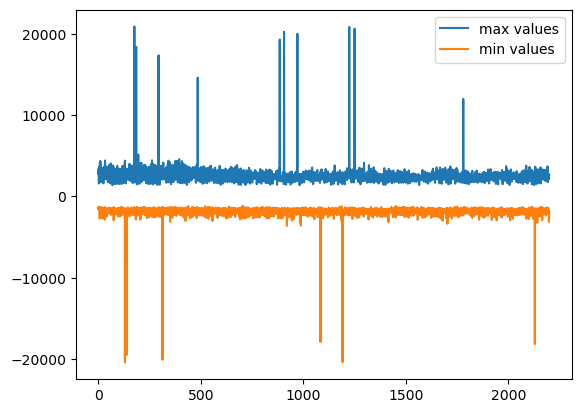

the number of cosmic ray poisoned images are : 16


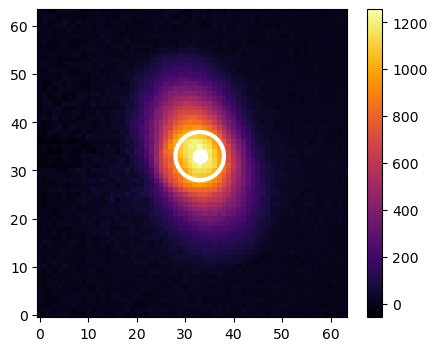

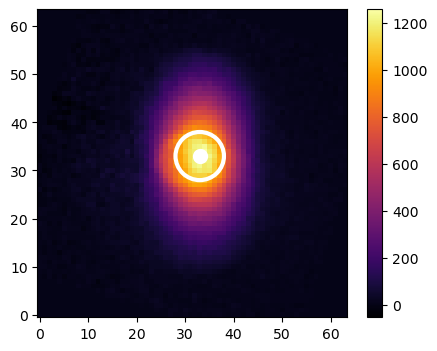

In [6]:
# check for existence of cosmic rays poisoned images
plt.plot(np.amax(Img, axis=(1,2)))
plt.plot(np.amin(Img, axis=(1,2)))
plt.legend(['max values','min values'])
plt.show()

# to put all images that are poisoned by cosmic ray
gamma_ray_img_ind = np.concatenate((np.where(np.amax(Img, axis=(1,2))>1E4)[0],np.where(np.amin(Img, axis=(1,2))<-1E4)[0]))
for ind in gamma_ray_img_ind:
    Img[ind] = Img[ind] * np.nan
print(f'the number of cosmic ray poisoned images are : {len(gamma_ray_img_ind)}')

# image rotation
Rotated_Img = np.array([ndimage.rotate(Img[_], -17, reshape=False, cval = 0) for _ in range(len(Img))])

# image integration
mol_center = [33, 33]
integration_window = 20
temp = Rotated_Img[:,mol_center[0]-int(integration_window/2):mol_center[0]+int(integration_window/2),:]
int_sig = np.mean(temp,axis=(1,2))
int_sig = int_sig.reshape(nimg // N_switch,N_switch).T # int_sig has shape of (N_switch, file num per stage)

display_CCD(np.nanmean(Img,axis=0), style = '2D', center = (33, 33), center_plot = True)
display_CCD(np.nanmean(Rotated_Img,axis=0), style = '2D', center = (33, 33), center_plot = True)

# find the ratios
ratios = np.array([int_sig[i]*2/(int_sig[i-1,:]+int_sig[i+1,:]) for i in [1,3,5,7,9]])

ratios[0] -= 1

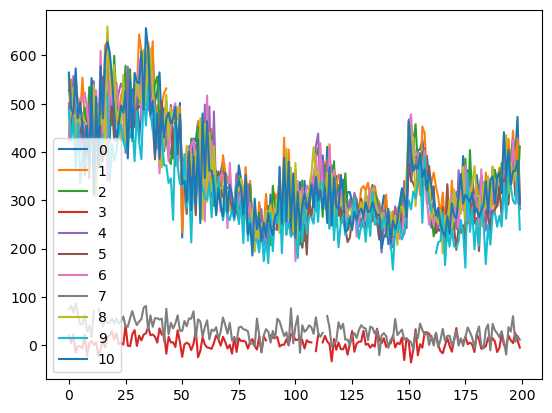

[0.04773056 0.01776897 0.9396207  0.08585123 0.8662091 ] [0.13905789 0.04149957 0.12351035 0.05568172 0.13336529]


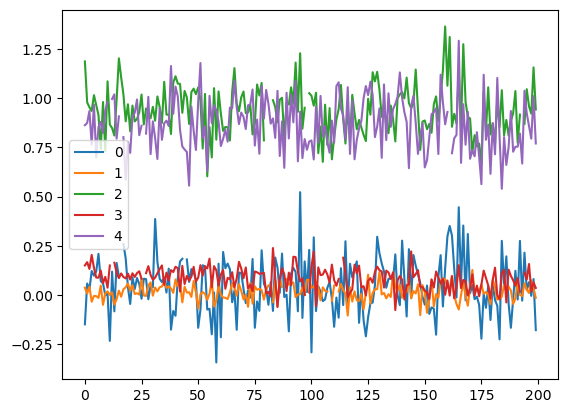

In [7]:
%matplotlib inline  
for i in range(N_switch):
    plt.plot(int_sig[i,:], label = f'{i}')
plt.legend()
plt.show()

for i in range(len(ratios)):
    plt.plot(ratios[i,:], label = f'{i}')
plt.legend()

ratio_means = np.nanmean(ratios, axis=1)
ratio_std = np.nanstd(ratios, axis=1)
print(ratio_means, ratio_std)

In [8]:
np.count_nonzero(np.isnan(ratios))

20

In [9]:
clean_ratios = list(ratios)
clean_ratios = [clean_ratios[_][np.logical_not(np.isnan(clean_ratios[_]))] for _ in range(len(clean_ratios))]
n_clean_ratios = [len(clean_ratios[_]) for _ in range(len(clean_ratios))]

print([np.mean(clean_ratios[i]) for i in range(5)])
print([2*np.std(clean_ratios[i])/np.sqrt(n_clean_ratios[i]) for i in range(5)])

[0.04773055, 0.01776897, 0.93962073, 0.08585122, 0.8662091]
[0.01976482566438137, 0.005928511066096169, 0.017689519147406015, 0.00797490163467374, 0.01905218405382974]


# predissociation rate calculation class

In [10]:
class BState_Predissociation(object):
    def __init__(self, experiment='v0', new_VBR=None):
        self.experiment = experiment
        self.new_VBR = new_VBR
        self.var_assignment()
        self.VBR_assignment()
        
    def var_assignment(self):
        if self.experiment == 'v0':
            self.n1, self.k, self.dA, self.dB = symbols('n1, k, dA, dB')
            self.r1, self.r2, self.r3, self.r4, self.r5 = symbols('r1, r2, r3, r4, r5')
            self.n_var = 5
        elif self.experiment == 'v1m1':
            self.n1, self.k, self.a, self.dB = symbols('n1, k, a, dB')
            self.r1, self.r2, self.r3, self.r4, self.r5 = symbols('r1, r2, r3, r4, r5')
            self.n_var = 5
        elif self.experiment == 'v1m2':
            self.n1, self.k1, self.k2, self.a, self.dA, self.dB = symbols('n1, k1, k2, a, dA, dB')
            self.r1, self.r2, self.r3, self.r4, self.r5, self.r6, self.r7, self.r8, self.r9 = symbols('r1, r2, r3, r4, r5, r6, r7, r8, r9')
            self.n_var = 7
        
    def VBR_assignment(self):
        self.Fa00, self.Fa01, self.Fa02, self.Fa03, self.Fb00, self.Fb01, self.Fb02, self.Fb03, self.Fa10, self.Fa11, self.Fa12, self.Fa13, self.Fb10, self.Fb11, self.Fb12, self.Fb13 = symbols('Fa00, Fa01, Fa02, Fa03, Fb00, Fb01, Fb02, Fb03, Fa10, Fa11, Fa12, Fa13, Fb10, Fb11, Fb12, Fb13')
        self.Fb0a, self.Fb1a = symbols('Fb0a, Fb1a')
        self.Fa0 = self.Fa01 + self.Fa02 + self.Fa03
        self.Fa1 = self.Fa00 + self.Fa02 + self.Fa03
        self.Fa2 = self.Fa11 + self.Fa12 + self.Fa13
        self.Fa3 = self.Fa10 + self.Fa12 + self.Fa13
        self.Fa4 = self.Fa10 + self.Fa11 + self.Fa13
        self.Fb0 = self.Fb00 + self.Fb02 + self.Fb03 + self.Fb0a
        self.Fb1 = self.Fb01 + self.Fb02 + self.Fb03 + self.Fb0a
        self.Fb2 = self.Fb10 + self.Fb12 + self.Fb13 + self.Fb1a

        if self.new_VBR == None:
            self.fa0 = [0.988126,0.01159,0.000284385,0.]
            self.fb0 = [0.988982,0.010313,0.000659759,0.0000453123]
            self.fa1 = [0.0202488,0.956131,0.0226918,0.000928542]
            self.fb1 = [0.0179405,0.961639,0.0184092,0.00201134]
        else:
            self.fa0 = self.new_VBR[0]
            self.fb0 = self.new_VBR[1]
            self.fa1 = self.new_VBR[2]
            self.fb1 = self.new_VBR[3]
            print('new VBR implemented')
            
        self.VBRs = {self.Fa00: self.fa0[0], 
               self.Fa01: self.fa0[1],
               self.Fa02: self.fa0[2],
               self.Fa03: self.fa0[3],
               self.Fb00: self.fb0[0], 
               self.Fb01: self.fb0[1],
               self.Fb02: self.fb0[2],
               self.Fb03: self.fb0[3],
               self.Fa10: self.fa1[0], 
               self.Fa11: self.fa1[1],
               self.Fa12: self.fa1[2],
               self.Fa13: self.fa1[3],
               self.Fb10: self.fb1[0], 
               self.Fb11: self.fb1[1],
               self.Fb12: self.fb1[2],
               self.Fb13: self.fb1[3]}
            
    def build_eqn(self):
        if self.experiment == 'v0':
            eq1 = self.n1 * self.k * self.Fb00 / self.Fb0 - self.r1
            eq2 = self.dA - self.r2
            eq3 = self.dA + ((1-self.dA) * self.Fa01 / self.Fa0 + self.n1)*self.k*self.Fb00/self.Fb0 - self.r3
            eq4 = self.dB - self.r4
            eq5 = self.dB + ((1-self.dB) * self.Fb01 / self.Fb1 + self.n1)*self.k*self.Fb00/self.Fb0 - self.r5
            self.solution = solve([eq1, eq2, eq3, eq4, eq5],(self.n1, self.k, self.Fb0a, self.dA, self.dB),dict=True)
            self.rate = lambdify([self.r1, self.r2, self.r3, self.r4, self.r5, 
                                  self.Fa00, self.Fa01, self.Fa02, self.Fa03, 
                                  self.Fb00, self.Fb01, self.Fb02, self.Fb03, 
                                  self.Fa10, self.Fa11, self.Fa12, self.Fa13, 
                                  self.Fb10, self.Fb11, self.Fb12, self.Fb13], self.solution[0][self.Fb0a], "numpy" )
            print(self.solution[0][self.Fb0a])
        elif self.experiment == 'v1m1':
            eq1 = Float(1.0) - self.a - self.r1
            eq2 = Float(1.0) + self.n1 * self.k * self.Fa00 / self.Fa1 - self.r2
            eq3 = Float(1.0) - self.a + (self.n1 + self.a * self.Fa11 / self.Fa2)*self.k*self.Fa00/self.Fa1 - self.r3
            eq4 = Float(1.0) - self.a + (self.n1 + self.a * self.Fa11 / self.Fa2)*self.dB*self.Fb10/self.Fb2 - self.r4
            eq5 = Float(1.0) - self.a + (self.n1 + self.a * self.Fa11 / self.Fa2)*(self.dB*self.Fb10/self.Fb2 + (Float(1.0)-self.dB) * self.k*self.Fa00 / self.Fa1) - self.r5
            self.solution = solve([eq1, eq2, eq3, eq4, eq5],(self.n1, self.k, self.a, self.dB, self.Fb1a),dict=True)
            self.rate = lambdify([self.r1, self.r2, self.r3, self.r4, self.r5, 
                                  self.Fa00, self.Fa01, self.Fa02, self.Fa03, 
                                  self.Fb00, self.Fb01, self.Fb02, self.Fb03, 
                                  self.Fa10, self.Fa11, self.Fa12, self.Fa13, 
                                  self.Fb10, self.Fb11, self.Fb12, self.Fb13], self.solution[0][self.Fb1a], "numpy" )
            print(self.solution[0][self.Fb1a])
        

There are four ways to present the statistical mean of the data set. Define our language: we took 200 sets of {r1,r2,r3,r4,r5}, and acquired 200 resulting f by the analytical expression.

M1: Treat as a regular measurement. Assume 200 measurements are completely independent measurements, and take average as f_hat, and take STD/sqrt(n) as 1-sigma confidence. Cons: require some assumptions, and can be questioned most.

M2: Pair-wise bootstrapping. We got 200 measured f, (1) we randomly select 200 f from the database (allow repetition, aka sampling with replacement) (2) calculate mean and save to array F (3) repeat 1-2 millions times (4) take the distribution of f and get the 95% quantile. 

M3: Model-based bootstrapping. We got 200 measured r_i. (1) we randomly sample with replacement 200 r1, 200 r2, ..., 200 r5 (2) calculate 200 f and take the mean and save to array F (3) repeat 1-2 millions times (4) analyze the distribution.

M4: Model-based raw data boostrapping. We got 200 measured r_i. (1) we randomly sample with replacement 200 r1, 200 r2, ..., 200 r5 (2) calculate 1 set of r1_hat and r2_hat, and use them to calculate one f, and save it to array F (3) repeat 1-2 millions times (4) analyze the distribution.


The more assumptions you make, the higher chance other people will come and get picky at you. We should not assume ri are gaussians, but to let the data tell the story. Below I'll examine all four methods. I'll also include the ri_hat to calculate f_hat but obviously it's wrong but just to show.

## Method 1

In [12]:
Ramanaiah_1982 = [[0.988126,0.01159,0.000284385,0. ],
        [0.988982,0.010313,0.000659759,0.0000453123 ],
        [0.02025,0.956186,0.0226931,0.000870559],
        [0.017946,0.961932,0.0184149,0.00170712]]
GaoGao_Ramanaiah = [[0.964575,0.0337492,0.00157125,0.000104298],
        [0.988982,0.010313,0.000659759,0.0000453123],
        [0.0606399,0.869608,0.0648207,0.00493135],
        [0.017946,0.961932,0.0184149,0.00170712]]
final = [[0.983924886090313, 0.015670427423045, 0.000387589525233, 0.000017096961409],
        [0.983838058252184, 0.015032752343161, 0.001064547175323, 0.000064642229332],
        [0.027427211253924, 0.938980912777852, 0.032342075825530, 0.001249800142693],
        [0.026338483319052, 0.948006057470233, 0.022700476086103, 0.002954983124613]]

t = BState_Predissociation('v0', new_VBR = final)
t.build_eqn()

new VBR implemented
(-Fa01*Fb01*r1*r2 + Fa01*Fb01*r1*r4 + Fa01*Fb01*r2*r5 - Fa01*Fb01*r2 - Fa01*Fb01*r3*r4 + Fa01*Fb01*r3 + Fa01*Fb01*r4 - Fa01*Fb01*r5 - Fa01*Fb02*r1*r2 + Fa01*Fb02*r1 - Fa01*Fb02*r2*r4 + Fa01*Fb02*r2*r5 + Fa01*Fb02*r4 - Fa01*Fb02*r5 - Fa01*Fb03*r1*r2 + Fa01*Fb03*r1 - Fa01*Fb03*r2*r4 + Fa01*Fb03*r2*r5 + Fa01*Fb03*r4 - Fa01*Fb03*r5 + Fa02*Fb01*r1*r4 - Fa02*Fb01*r1 + Fa02*Fb01*r2*r4 - Fa02*Fb01*r2 - Fa02*Fb01*r3*r4 + Fa02*Fb01*r3 + Fa03*Fb01*r1*r4 - Fa03*Fb01*r1 + Fa03*Fb01*r2*r4 - Fa03*Fb01*r2 - Fa03*Fb01*r3*r4 + Fa03*Fb01*r3)/(Fa01*(r1*r2 - r1 + r2*r4 - r2*r5 - r4 + r5))


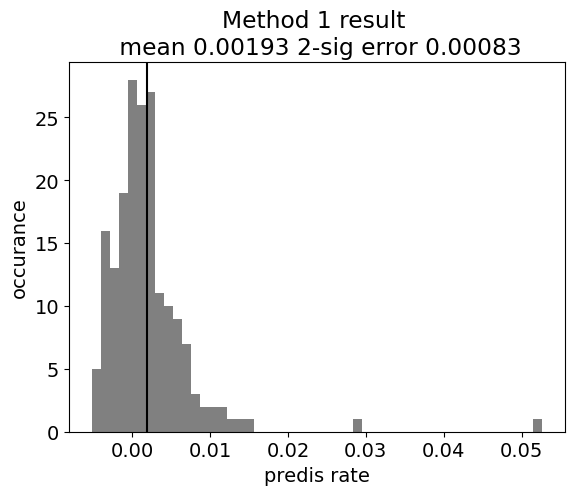

In [13]:
f_list = t.rate(*list(ratios)+t.fa0+t.fb0+t.fa1+t.fb1)
f_list = f_list[np.abs(f_list)<1]
plt.hist(f_list,bins=50,facecolor='gray')
plt.axvline(x=np.nanmean(f_list),c='black')
plt.xlabel('predis rate')
plt.ylabel('occurance')
plt.title(f'Method 1 result \n mean {np.nanmean(f_list):.5f} 2-sig error {2*np.nanstd(f_list)/np.sqrt(len(f_list)):.5f}')
plt.show()
v0_result_m1 = [np.nanmean(f_list), 2*np.nanstd(f_list)/np.sqrt(len(f_list)), 2*np.nanstd(f_list)/np.sqrt(len(f_list))]

## Method 4

In [14]:
clean_ratios = list(ratios)
clean_ratios = [clean_ratios[_][np.logical_not(np.isnan(clean_ratios[_]))] for _ in range(len(clean_ratios))]
n_clean_ratios = [len(clean_ratios[_]) for _ in range(len(clean_ratios))]

n_bootstrap = 1000000
list_boostrap = np.empty(n_bootstrap)
for bt_index in tqdm(range(n_bootstrap)):
    temp_ri = [np.mean(clean_ratios[_][np.random.randint(0, n_clean_ratios[_],size=185)]) for _ in range(5)]
    temp_list = t.rate(*temp_ri+t.fa0+t.fb0+t.fa1+t.fb1)
    list_boostrap[bt_index] = np.mean(temp_list)

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [04:46<00:00, 3493.02it/s]


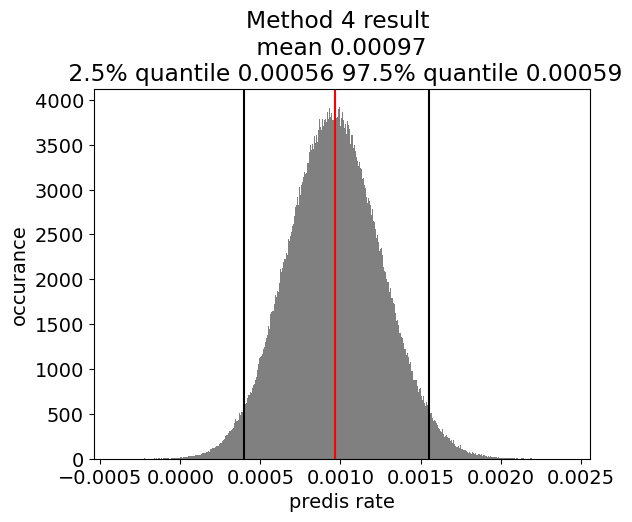

In [15]:
plt.hist(list_boostrap,bins=1000,facecolor='gray')
ave = np.mean(list_boostrap)
lower = np.percentile(list_boostrap, 2.5)
higher = np.percentile(list_boostrap, 97.5) 
plt.axvline(x=np.mean(list_boostrap),c='red')
plt.axvline(x=lower,c='black')
plt.axvline(x=higher,c='black')

plt.xlabel('predis rate')
plt.ylabel('occurance')
plt.title(f'Method 4 result \n mean {np.mean(list_boostrap):.5f} \n 2.5% quantile {ave - lower:.5f} 97.5% quantile {higher - ave:.5f}')
plt.show()
v0_result_m4 = [np.mean(list_boostrap), ave - lower, higher - ave]

## Comparison of methods

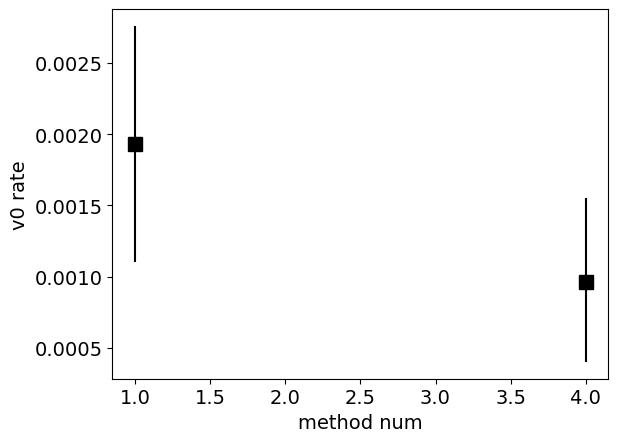

In [16]:
avg = [v0_result_m1[0], v0_result_m4[0]]
low = [v0_result_m1[1], v0_result_m4[1]]
high = [v0_result_m1[2], v0_result_m4[2]]
f, ax = plt.subplots()
ax.errorbar([1,4], avg, yerr = ([low, high]), ls='none', marker = 's', c='black', ms=10)
plt.xlabel('method num')
plt.ylabel('v0 rate')
plt.show()

# v1 rate calculation
## Oct 11 File 13

In [17]:
str_prefix = 'D:\\Server_Files\\hydridet\\My Libraries\\CryoMolEx\\CryoMolExData\\'
str_date = '2022\\10-Oct\\2022-10-11\\2022-10-11_Waveforms'
cahnum = [13]
Img = []
N_switch = 11

for filenum in cahnum:
    str_num = f'{filenum}\\'
    filename = str_prefix + str_date + str_num
    Img_new, _ = import_img(filename, N_switch=N_switch)
    Img += Img_new
    
nimg = len(Img)
avgimg = np.mean(np.array(Img),axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 1760/1760 [00:04<00:00, 432.53it/s]


images import done


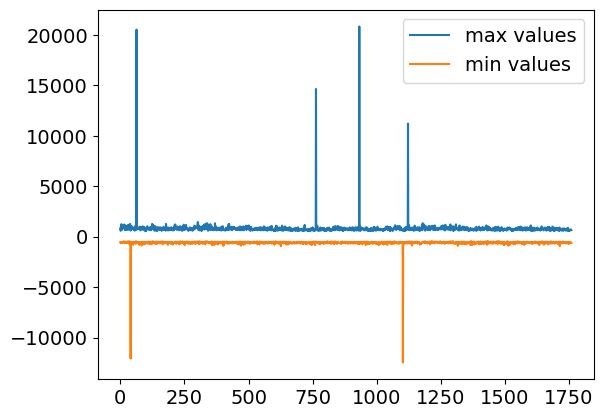

the number of cosmic ray poisoned images are : 6


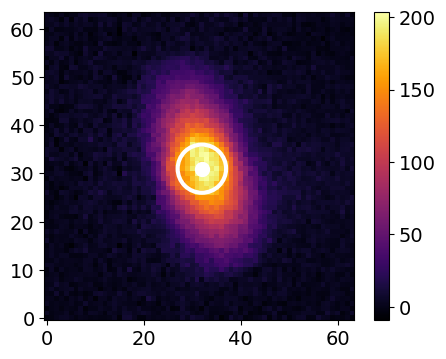

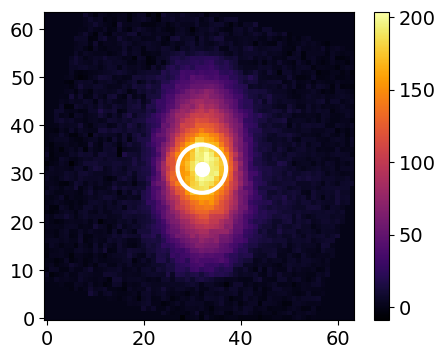

In [18]:
# check for existence of cosmic rays poisoned images
plt.plot(np.amax(Img, axis=(1,2)))
plt.plot(np.amin(Img, axis=(1,2)))
plt.legend(['max values','min values'])
plt.show()

# to put all images that are poisoned by cosmic ray
gamma_ray_img_ind = np.concatenate((np.where(np.amax(Img, axis=(1,2))>1E4)[0],np.where(np.amin(Img, axis=(1,2))<-1E4)[0]))
for ind in gamma_ray_img_ind:
    Img[ind] = Img[ind] * np.nan
print(f'the number of cosmic ray poisoned images are : {len(gamma_ray_img_ind)}')

# image rotation
Rotated_Img = np.array([ndimage.rotate(Img[_], -15, reshape=False, cval = 0) for _ in range(len(Img))])

# image integration
mol_center = [32, 31]
integration_window = 20
temp = Rotated_Img[:,mol_center[0]-int(integration_window/2):mol_center[0]+int(integration_window/2),:]
int_sig = np.mean(temp,axis=(1,2))
int_sig = int_sig.reshape(nimg // N_switch,N_switch).T # int_sig has shape of (N_switch, file num per stage)

display_CCD(np.nanmean(Img,axis=0), style = '2D', center = (32, 31), center_plot = True)
display_CCD(np.nanmean(Rotated_Img,axis=0), style = '2D', center = (32, 31), center_plot = True)

# find the ratios
ratios = np.array([int_sig[i]*2/(int_sig[i-1,:]+int_sig[i+1,:]) for i in [1,3,5,7,9]])

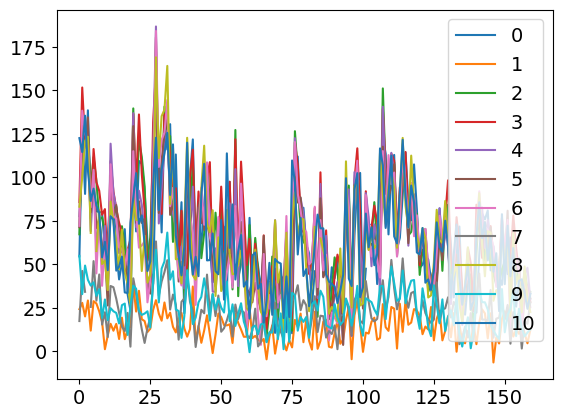

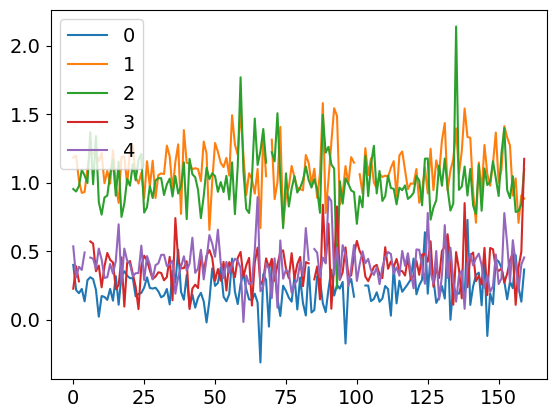

the ratios and stds and err
[0.22314236 1.0961914  1.0087457  0.38534382 0.39972773] [0.13444163 0.17785013 0.19995075 0.14767557 0.14187156] [0.0106956  0.014149   0.01585713 0.01178579 0.0112867 ]


In [19]:
%matplotlib inline  
for i in range(N_switch):
    plt.plot(int_sig[i,:], label = f'{i}')
plt.legend()
plt.show()

for i in range(len(ratios)):
    plt.plot(ratios[i,:], label = f'{i}')
plt.legend()
plt.show()

clean_ratios = list(ratios)
clean_ratios = [clean_ratios[_][np.logical_not(np.isnan(clean_ratios[_]))] for _ in range(len(clean_ratios))]
n_clean_ratios = [len(clean_ratios[_]) for _ in range(len(clean_ratios))]
ratio_means = np.array([np.mean(clean_ratios[_]) for _ in range(5)])
ratio_std = np.array([np.std(clean_ratios[_]) for _ in range(5)])
print('the ratios and stds and err')
print(ratio_means, ratio_std, ratio_std / np.sqrt(n_clean_ratios))

In [20]:
np.count_nonzero(np.isnan(ratios))

10

In [21]:
clean_ratios = list(ratios)
clean_ratios = [clean_ratios[_][np.logical_not(np.isnan(clean_ratios[_]))] for _ in range(len(clean_ratios))]
n_clean_ratios = [len(clean_ratios[_]) for _ in range(len(clean_ratios))]

print([np.mean(clean_ratios[i]) for i in range(5)])
print([2*np.std(clean_ratios[i])/np.sqrt(n_clean_ratios[i]) for i in range(5)])

[0.22314236, 1.0961914, 1.0087457, 0.38534382, 0.39972773]
[0.02139120345777981, 0.02829799284031473, 0.03171425260695271, 0.023571587725325985, 0.022573390060408035]


In [22]:
t = BState_Predissociation('v1m1', new_VBR = final)
t.build_eqn()

new VBR implemented
(-Fa11*Fb10*r1*r2 + Fa11*Fb10*r1*r5 + Fa11*Fb10*r2*r4 - Fa11*Fb10*r3*r4 + Fa11*Fb10*r3 - Fa11*Fb10*r5 - Fa11*Fb12*r1**2 - Fa11*Fb12*r1*r2 + Fa11*Fb12*r1*r3 + Fa11*Fb12*r1*r4 + Fa11*Fb12*r1 + Fa11*Fb12*r2*r4 - Fa11*Fb12*r3*r4 - Fa11*Fb12*r4 - Fa11*Fb13*r1**2 - Fa11*Fb13*r1*r2 + Fa11*Fb13*r1*r3 + Fa11*Fb13*r1*r4 + Fa11*Fb13*r1 + Fa11*Fb13*r2*r4 - Fa11*Fb13*r3*r4 - Fa11*Fb13*r4 - Fa12*Fb10*r1**2 - Fa12*Fb10*r1*r2 + Fa12*Fb10*r1*r3 + Fa12*Fb10*r1*r4 + Fa12*Fb10*r1 + Fa12*Fb10*r2*r4 - Fa12*Fb10*r3*r4 - Fa12*Fb10*r4 - Fa12*Fb12*r1**2 - Fa12*Fb12*r1*r2 + Fa12*Fb12*r1*r3 + Fa12*Fb12*r1*r4 + Fa12*Fb12*r1 + Fa12*Fb12*r2*r4 - Fa12*Fb12*r3*r4 - Fa12*Fb12*r4 - Fa12*Fb13*r1**2 - Fa12*Fb13*r1*r2 + Fa12*Fb13*r1*r3 + Fa12*Fb13*r1*r4 + Fa12*Fb13*r1 + Fa12*Fb13*r2*r4 - Fa12*Fb13*r3*r4 - Fa12*Fb13*r4 - Fa13*Fb10*r1**2 - Fa13*Fb10*r1*r2 + Fa13*Fb10*r1*r3 + Fa13*Fb10*r1*r4 + Fa13*Fb10*r1 + Fa13*Fb10*r2*r4 - Fa13*Fb10*r3*r4 - Fa13*Fb10*r4 - Fa13*Fb12*r1**2 - Fa13*Fb12*r1*r2 + Fa13*Fb12*r1

## Method 1

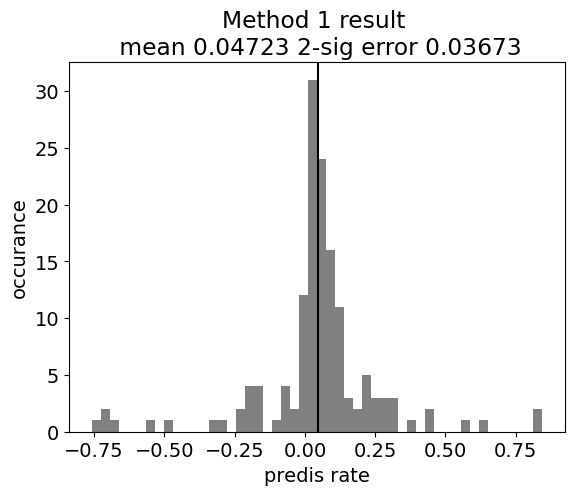

In [23]:
f_list = t.rate(*list(ratios)+t.fa0+t.fb0+t.fa1+t.fb1)
f_list = f_list[np.abs(f_list)<1]
plt.hist(f_list,bins=50,facecolor='gray')
plt.axvline(x=np.nanmean(f_list),c='black')
plt.xlabel('predis rate')
plt.ylabel('occurance')
plt.title(f'Method 1 result \n mean {np.nanmean(f_list):.5f} 2-sig error {2*np.nanstd(f_list)/np.sqrt(len(f_list)):.5f}')
plt.show()
v1_g1_result_m1 = [np.nanmean(f_list), 2*np.nanstd(f_list)/np.sqrt(len(f_list)), 2*np.nanstd(f_list)/np.sqrt(len(f_list))]

## Method 4

In [24]:
clean_ratios = list(ratios)
clean_ratios = [clean_ratios[_][np.logical_not(np.isnan(clean_ratios[_]))] for _ in range(len(clean_ratios))]
n_clean_ratios = [len(clean_ratios[_]) for _ in range(len(clean_ratios))]
n_clean_ratios_min = min(n_clean_ratios)

n_bootstrap = 100000
list_boostrap = np.empty(n_bootstrap)
for bt_index in tqdm(range(n_bootstrap)):
    temp_ri = [np.mean(clean_ratios[_][np.random.randint(0, n_clean_ratios[_],size=n_clean_ratios_min)]) for _ in range(5)]
    temp_list = t.rate(*temp_ri+t.fa0+t.fb0+t.fa1+t.fb1)
    list_boostrap[bt_index] = np.mean(temp_list)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:48<00:00, 2068.39it/s]


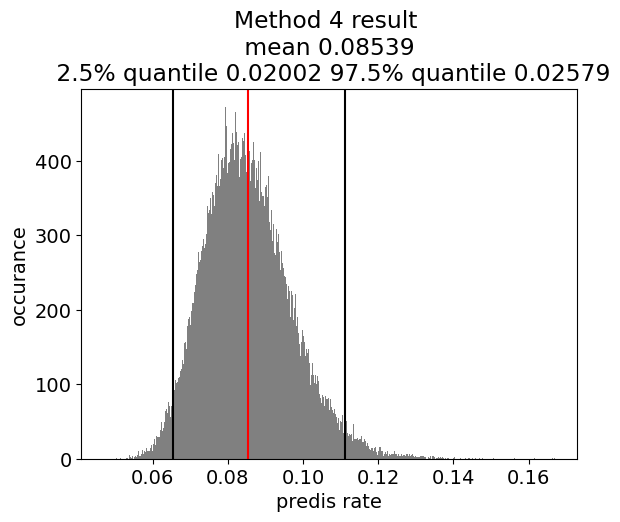

In [25]:
plt.hist(list_boostrap,bins=1000,facecolor='gray')
ave = np.mean(list_boostrap)
lower = np.percentile(list_boostrap, 2.5)
higher = np.percentile(list_boostrap, 97.5) 
plt.axvline(x=np.mean(list_boostrap),c='red')
plt.axvline(x=lower,c='black')
plt.axvline(x=higher,c='black')

plt.xlabel('predis rate')
plt.ylabel('occurance')
plt.title(f'Method 4 result \n mean {np.mean(list_boostrap):.5f} \n 2.5% quantile {ave - lower:.5f} 97.5% quantile {higher - ave:.5f}')
plt.show()
v1_g1_result_m4 = [np.mean(list_boostrap), ave - lower, higher - ave]

## Comparison of methods

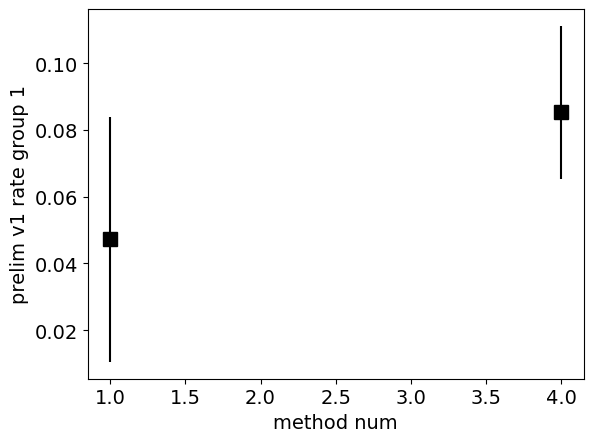

In [26]:
avg = [v1_g1_result_m1[0], v1_g1_result_m4[0]]
low = [v1_g1_result_m1[1], v1_g1_result_m4[1]]
high = [v1_g1_result_m1[2], v1_g1_result_m4[2]]
f, ax = plt.subplots()
ax.errorbar([1,4], avg, yerr = ([low, high]), ls='none', marker = 's', c='black', ms=10)
plt.xlabel('method num')
plt.ylabel('prelim v1 rate group 1')
plt.show()

# v1 rate calculation method 2
## Oct 13 File 5, 6

In [27]:
str_prefix = 'D:\\Server_Files\\hydridet\\My Libraries\\CryoMolEx\\CryoMolExData\\'
str_date = '2022\\10-Oct\\2022-10-13\\2022-10-13_Waveforms'
cahnum = [5, 6]
Img = []
N_switch = 19

for filenum in cahnum:
    str_num = f'{filenum}\\'
    filename = str_prefix + str_date + str_num
    Img_new, _ = import_img(filename, N_switch=N_switch)
    Img += Img_new
    
nimg = len(Img)
avgimg = np.mean(np.array(Img),axis=0)

100%|███████████████████████████████████████████████████████████████████████████████| 969/969 [00:02<00:00, 356.54it/s]


images import done


100%|███████████████████████████████████████████████████████████████████████████████| 950/950 [00:02<00:00, 363.73it/s]

images import done


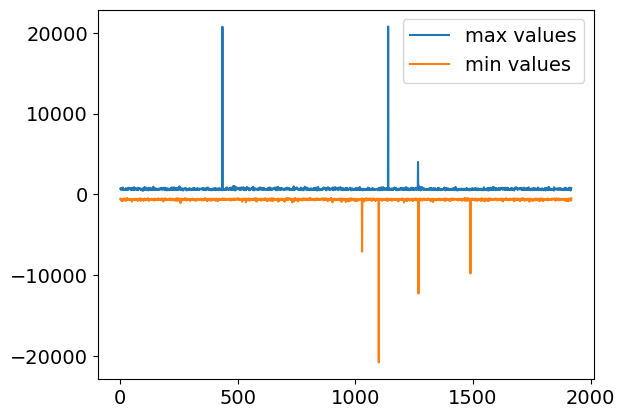

the number of cosmic ray poisoned images are : 7


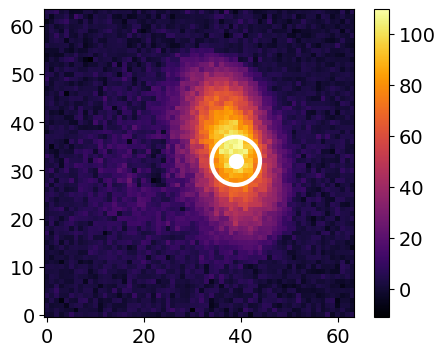

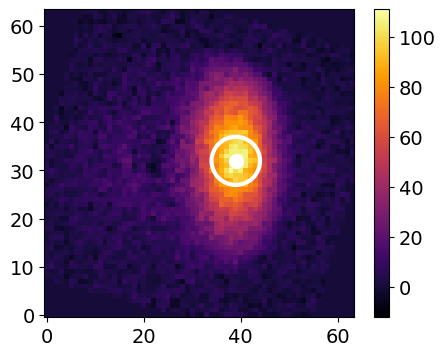

In [28]:
# check for existence of cosmic rays poisoned images
plt.plot(np.amax(Img, axis=(1,2)))
plt.plot(np.amin(Img, axis=(1,2)))
plt.legend(['max values','min values'])
plt.show()

# to put all images that are poisoned by cosmic ray
gamma_ray_img_ind = np.concatenate((np.where(np.amax(Img, axis=(1,2))>2E3)[0],np.where(np.amin(Img, axis=(1,2))<-2E3)[0]))
for ind in gamma_ray_img_ind:
    Img[ind] = Img[ind] * np.nan
print(f'the number of cosmic ray poisoned images are : {len(gamma_ray_img_ind)}')

# image rotation
Rotated_Img = np.array([ndimage.rotate(Img[_], -15, reshape=False, cval = 0) for _ in range(len(Img))])

# image integration
mol_center = [39, 32]
integration_window = 20
temp = Rotated_Img[:,mol_center[0]-int(integration_window/2):mol_center[0]+int(integration_window/2),:]
int_sig = np.mean(temp,axis=(1,2))
int_sig = int_sig.reshape(nimg // N_switch,N_switch).T # int_sig has shape of (N_switch, file num per stage)

# set the calibration images that have too low signal to np.nan
for i_temp in [0,2,4,6,8,10,12,14,16,18]:
    for j_temp in range(len(int_sig[0])):
        if int_sig[i_temp, j_temp] < 20:
            int_sig[i_temp, j_temp] = np.nan

display_CCD(np.nanmean(Img,axis=0), style = '2D', center = (39, 32), center_plot = True)
display_CCD(np.nanmean(Rotated_Img,axis=0), style = '2D', center = (39, 32), center_plot = True)

# find the ratios
ratios = np.array([int_sig[i]*2/(int_sig[i-1,:]+int_sig[i+1,:]) for i in [1,3,5,7,9,11,13,15,17]])

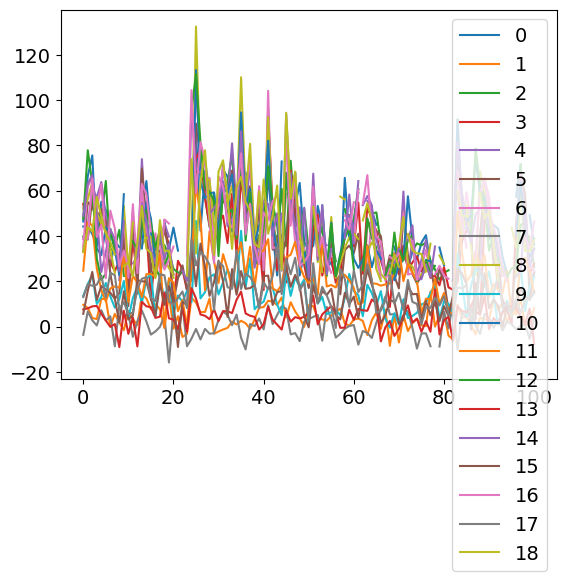

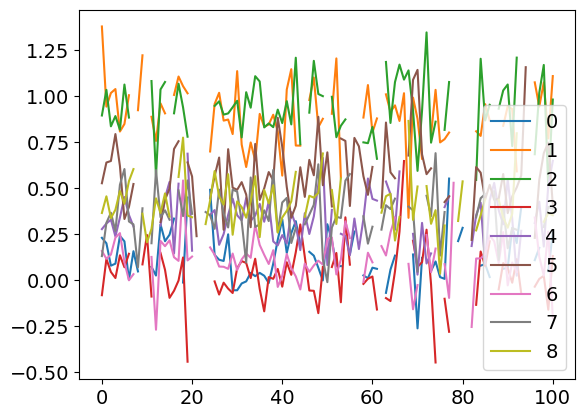

the ratios and stds and err
[0.13435721 0.8948296  0.9254249  0.02642789 0.33284765 0.5692399
 0.12237308 0.35458395 0.4164956 ] [0.13627332 0.16926864 0.16578762 0.15526493 0.14272492 0.1819823
 0.13662316 0.136771   0.1321393 ] [0.01533195 0.0191659  0.01889325 0.01746867 0.01566609 0.01973875
 0.01490681 0.01519678 0.01496183]


In [29]:
%matplotlib inline  
for i in range(N_switch):
    plt.plot(int_sig[i,:], label = f'{i}')
plt.legend()
plt.show()

for i in range(len(ratios)):
    plt.plot(ratios[i,:], label = f'{i}')
plt.legend()
plt.show()

clean_ratios = list(ratios)
clean_ratios = [clean_ratios[_][np.logical_not(np.isnan(clean_ratios[_]))] for _ in range(len(clean_ratios))]
n_clean_ratios = [len(clean_ratios[_]) for _ in range(len(clean_ratios))]
ratio_means = np.array([np.mean(clean_ratios[_]) for _ in range(9)])
ratio_std = np.array([np.std(clean_ratios[_]) for _ in range(9)])
print('the ratios and stds and err')
print(ratio_means, ratio_std, ratio_std / np.sqrt(n_clean_ratios))

In [30]:
np.count_nonzero(np.isnan(ratios))

185

In [31]:
clean_ratios = list(ratios)
clean_ratios = [clean_ratios[_][np.logical_not(np.isnan(clean_ratios[_]))] for _ in range(len(clean_ratios))]
n_clean_ratios = [len(clean_ratios[_]) for _ in range(len(clean_ratios))]

print([np.mean(clean_ratios[i]) for i in range(9)])
print([2*np.std(clean_ratios[i])/np.sqrt(n_clean_ratios[i]) for i in range(9)])

[0.13435721, 0.8948296, 0.9254249, 0.026427893, 0.33284765, 0.5692399, 0.12237308, 0.35458395, 0.4164956]
[0.030663893720441537, 0.03833179825802149, 0.037786506021785515, 0.03493733859702214, 0.03133218964806417, 0.03947750229265639, 0.029813617525472874, 0.03039355410469903, 0.029923657884212272]


In [32]:
test = [[0.967519870488173, 0.031141971952516, 0.001274696000414, 0.000063461558896],
        [0.985413368352755, 0.013580439337607, 0.000964897260252, 0.000041295049386],
        [0.060666770244584, 0.869996962707419, 0.064852456877873, 0.004483810170123],
        [0.023623233435554, 0.955216394584733, 0.018218355678365, 0.002942016301348]]
self = BState_Predissociation('v1m2', new_VBR = test)
# self = BState_Predissociation('v1m2', new_VBR = GaoGao_Ramanaiah)
# self = BState_Predissociation('v1m2', new_VBR = final)
self.build_eqn()
from scipy.optimize import fsolve, least_squares

new VBR implemented


## Method 1

In [33]:
Fa00 = self.fa0[0]
Fa01 = self.fa0[1]
Fa02 = self.fa0[2]
Fa03 = self.fa0[3]
Fb00 = self.fb0[0] 
Fb01 = self.fb0[1]
Fb02 = self.fb0[2]
Fb03 = self.fb0[3]
Fa10 = self.fa1[0] 
Fa11 = self.fa1[1]
Fa12 = self.fa1[2]
Fa13 = self.fa1[3]
Fb10 = self.fb1[0] 
Fb11 = self.fb1[1]
Fb12 = self.fb1[2]
Fb13 = self.fb1[3]
Fa0 = Fa01 + Fa02 + Fa03
Fa1 = Fa00 + Fa02 + Fa03
Fa2 = Fa11 + Fa12 + Fa13
Fa3 = Fa10 + Fa12 + Fa13
Fa4 = Fa10 + Fa11 + Fa13

def v1m2_fit(data):
    def f(x):
        eqs = np.zeros(9)
        n1, k1, k2, a, dA, dB, Fb1a = x
        Fb2 = Fb10 + Fb12 + Fb13 + Fb1a

        common = n1 + (a + k1 - a * k1) * Fa11 / Fa2
        Z = n1 + a * Fa11 / Fa2
        eqs[0] = n1 / common - data[0]
        eqs[1] = Z / common - data[1]
        eqs[2] = (n1 + k1 * Fa11 / Fa2) / common - data[2]
        eqs[3] = (Z * (1 - dA)) / common - data[3]
        eqs[4] = (Z * (1 - dA) + (1 - a + Z * dA * Fa10 / Fa3) * k1 * Fa11 / Fa2) / common - data[4]
        eqs[5] = (Z * (1 - dA) + (a * Fa12 / Fa2 + Z * dA * Fa12 / Fa3) * k2 * Fa11 / Fa4) / common - data[5]
        eqs[6] = (Z * (1 - dB)) / common - data[6]
        eqs[7] = (Z * (1 - dB) + (1 - a + Z * dB * Fb10 / Fb2) * k1 * Fa11 / Fa2) / common - data[7]
        eqs[8] = (Z * (1 - dB) + (a * Fa12 / Fa2 + Z * dB * Fb12 / Fb2) * k2 * Fa11 / Fa4) / common - data[8]
        return eqs

    j = least_squares(f, [0.09, 0.9, 0.9, 0.9, 0.2, 0.3, 0], method='lm')
    return j.x[-1]

54 101


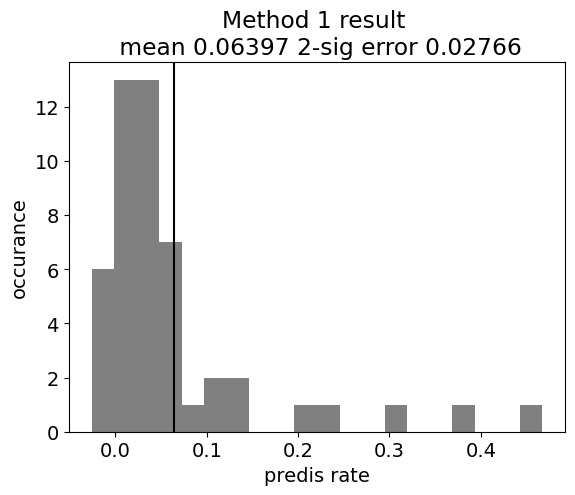

In [34]:
r_list = [ratios[:,_] for _ in range(len(ratios[0])) if not any(np.isnan(ratios[:,_]))]
print(len(r_list), len(ratios[0,:]))

f_list = np.array([v1m2_fit(r_list[ind]) for ind in range(len(r_list))])

f_list = f_list[np.abs(f_list)<0.5]
plt.hist(f_list,bins=20,facecolor='gray')
plt.axvline(x=np.nanmean(f_list),c='black')
plt.xlabel('predis rate')
plt.ylabel('occurance')
plt.title(f'Method 1 result \n mean {np.nanmean(f_list):.5f} 2-sig error {2*np.nanstd(f_list)/np.sqrt(len(f_list)):.5f}')
plt.show()
v1_g2_result_m1 = [np.nanmean(f_list), 2*np.nanstd(f_list)/np.sqrt(len(f_list)), 2*np.nanstd(f_list)/np.sqrt(len(f_list))]

## Method 4

In [35]:
clean_ratios = list(ratios)
clean_ratios = [clean_ratios[_][np.logical_not(np.isnan(clean_ratios[_]))] for _ in range(len(clean_ratios))]
n_clean_ratios = [len(clean_ratios[_]) for _ in range(len(clean_ratios))]
n_clean_ratios_min = min(n_clean_ratios)

n_bootstrap = 10000
list_boostrap = np.empty(n_bootstrap)
for bt_index in tqdm(range(n_bootstrap)):
    temp_ri = np.array([np.mean(clean_ratios[_][np.random.randint(0, n_clean_ratios[_],size=n_clean_ratios_min)]) for _ in range(9)]).T
    list_boostrap[bt_index] = v1m2_fit(temp_ri)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 501.26it/s]


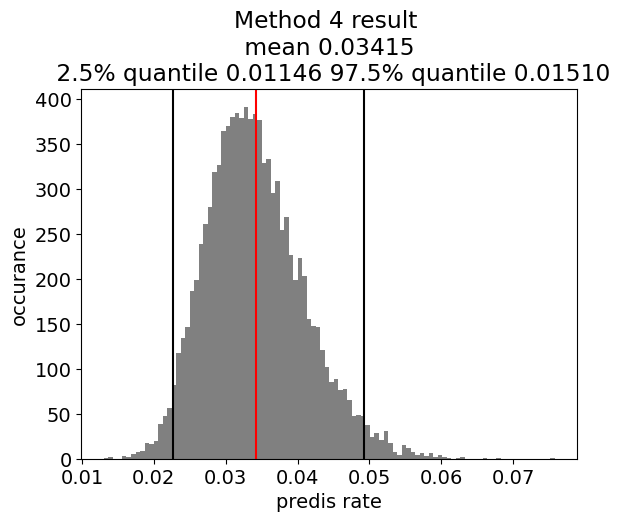

In [36]:
plt.hist(list_boostrap,bins=100,facecolor='gray')
ave = np.mean(list_boostrap)
lower = np.percentile(list_boostrap, 2.5)
higher = np.percentile(list_boostrap, 97.5) 
plt.axvline(x=np.mean(list_boostrap),c='red')
plt.axvline(x=lower,c='black')
plt.axvline(x=higher,c='black')

plt.xlabel('predis rate')
plt.ylabel('occurance')
plt.title(f'Method 4 result \n mean {np.mean(list_boostrap):.5f} \n 2.5% quantile {ave - lower:.5f} 97.5% quantile {higher - ave:.5f}')
plt.show()
v1_g2_result_m4 = [np.mean(list_boostrap), ave - lower, higher - ave]

###### Comparison of methods

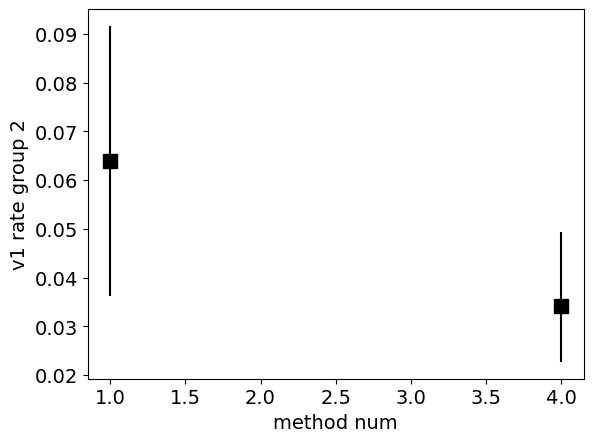

In [37]:
avg = [v1_g2_result_m1[0], v1_g2_result_m4[0]]
low = [v1_g2_result_m1[1], v1_g2_result_m4[1]]
high = [v1_g2_result_m1[2], v1_g2_result_m4[2]]
f, ax = plt.subplots()
ax.errorbar([1,4], avg, yerr = ([low, high]), ls='none', marker = 's', c='black', ms=10)
plt.xlabel('method num')
plt.ylabel('v1 rate group 2')
plt.show()